## This project uses Linear Regression to predict the number of bike share

### Import libraries and set some secret variable

In [109]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression



curious_me = False

### Read the data

In [2]:
# fetch dataset 
bike_sharing = fetch_ucirepo(id=275) 

In [3]:
# data (as pandas dataframes) 
X = bike_sharing.data.features 
y = bike_sharing.data.targets 

# convert y to shape of (samples, )
y = np.array(object=y)
y = y.ravel()
  
# metadata 
# print(bike_sharing.metadata) 
  
# variable information 
print(bike_sharing.variables) 

          name     role         type demographic  \
0      instant       ID      Integer        None   
1       dteday  Feature         Date        None   
2       season  Feature  Categorical        None   
3           yr  Feature  Categorical        None   
4         mnth  Feature  Categorical        None   
5           hr  Feature  Categorical        None   
6      holiday  Feature       Binary        None   
7      weekday  Feature  Categorical        None   
8   workingday  Feature       Binary        None   
9   weathersit  Feature  Categorical        None   
10        temp  Feature   Continuous        None   
11       atemp  Feature   Continuous        None   
12         hum  Feature   Continuous        None   
13   windspeed  Feature   Continuous        None   
14      casual    Other      Integer        None   
15  registered    Other      Integer        None   
16         cnt   Target      Integer        None   

                                          description units mis

In [4]:
print(X.head())
print(X.shape, y.shape)

       dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0  2011-01-01       1   0     1   0        0        6           0           1   
1  2011-01-01       1   0     1   1        0        6           0           1   
2  2011-01-01       1   0     1   2        0        6           0           1   
3  2011-01-01       1   0     1   3        0        6           0           1   
4  2011-01-01       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed  
0  0.24  0.2879  0.81        0.0  
1  0.22  0.2727  0.80        0.0  
2  0.22  0.2727  0.80        0.0  
3  0.24  0.2879  0.75        0.0  
4  0.24  0.2879  0.75        0.0  
(17379, 13) (17379,)


### Drop the dteday and the yr features
We drop the `dteday` (the exact date) feature since it only gives the exact date. Also, the data type is not train-able.

We drop the `yr` (year) feature since it is either 0 or 1 to indicate if it is the first or the second year of the data collection. If we want to further use the model to predict the count of total rental bikes, then the input year will be 2, 3, 4, etc, which are unseen. Also, two years (either 0 or 1) are not enough to predict the future. 

In [5]:
X = X.drop(axis=1, columns=['dteday', 'yr'])

In [6]:
X = pd.DataFrame(X)

print(X.head())

   season  mnth  hr  holiday  weekday  workingday  weathersit  temp   atemp  \
0       1     1   0        0        6           0           1  0.24  0.2879   
1       1     1   1        0        6           0           1  0.22  0.2727   
2       1     1   2        0        6           0           1  0.22  0.2727   
3       1     1   3        0        6           0           1  0.24  0.2879   
4       1     1   4        0        6           0           1  0.24  0.2879   

    hum  windspeed  
0  0.81        0.0  
1  0.80        0.0  
2  0.80        0.0  
3  0.75        0.0  
4  0.75        0.0  


### Data normalisation

Text(0.5, 1.0, 'After normalisation')

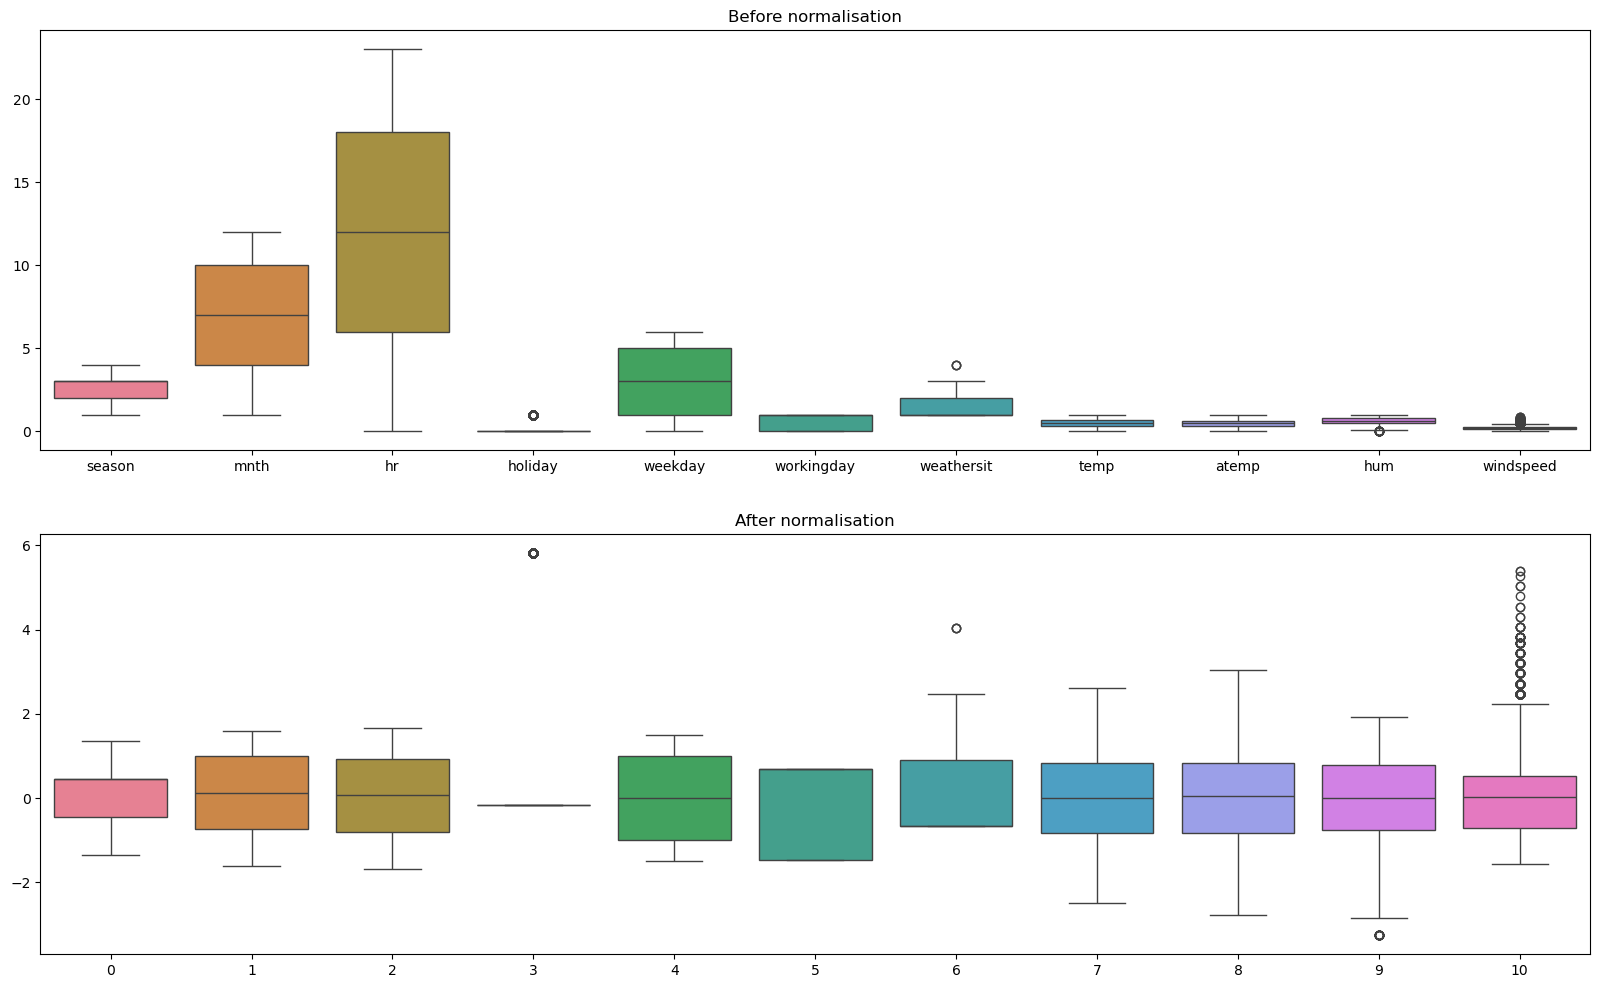

In [23]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

fig,ax=plt.subplots(2, 1,figsize=(20,12))
ax[0] = sns.boxplot(data=X, ax=ax[0])
ax[1] = sns.boxplot(data=Xs, ax=ax[1])
ax[0].set_title("Before normalisation")
ax[1].set_title("After normalisation")

### Split the data into training set and test set

In [24]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13903, 11)
(3476, 11)
(13903,)
(3476,)


### Feature selection

The cell below is just me being curious about which features the two `score_func`s consider to be the least important.

In [26]:
if curious_me:
  print(f"Upper: f_regression\nLower: mutual_info_regression")
  for i in range(0, 3):
    for k in range(10, 1, -1):
      for func in [f_regression, mutual_info_regression]:
        fs = SelectKBest(score_func=func, k=k)
        fs = fs.fit(X_train, y_train)

        X_train_new = fs.transform(X_train)
        X_test_new = fs.transform(X_test)

        features = X.columns.to_list()
        dropped_features = [feature for feature, retain in zip(features, fs.get_support()) if not retain]

        print(f"{dropped_features}")
      print()


Well... hmmmmm... I can't believe `holiday` is one of the least important features... And also, the least important features change every run.

### Create the model

#### Linear Regression Model, with normalised input.

This model is evaluated by K-fold cross validation. The score is the average of the k-fold. 

Also, a histogram shows the Negative-RMS error of the testing set.

Average Negative RMSE of k-fold cross validation is -147.49799429343565


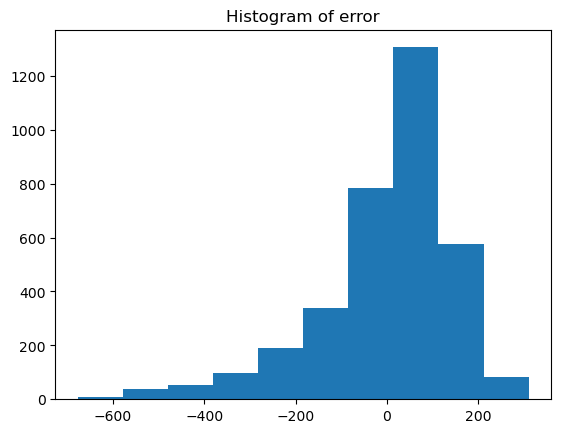

In [87]:
K = 7

model = LinearRegression()
model.fit(X_train, y_train)
score = cross_val_score(estimator=model, X=X_test, y=y_test, cv=K, scoring="neg_root_mean_squared_error")

y_predict = model.predict(X_test)

fig, ax = plt.subplots(1, 1)
ax.hist(y_predict - y_test)
ax.set_title("Histogram of error")

print(f"Average Negative-RMSE of k-fold cross validation is {np.average(score)}")

#### Linear Regression Model, with RFE (Recursive Feature Elimination) and normalised input.

Just due to curiosity, we want to know which features the RFE considers less important.

In [99]:
model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=5)

rfe = rfe.fit(X=X_train, y=y_train)

list(zip(X.columns,rfe.support_,rfe.ranking_))


[('season', True, 1),
 ('mnth', False, 6),
 ('hr', True, 1),
 ('holiday', False, 2),
 ('weekday', False, 3),
 ('workingday', False, 5),
 ('weathersit', False, 7),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', False, 4)]

We can see the RFE considers `weathersit` is the least important, followed by `mnth` and `workingday`.

Now, we use Grid Search Cross Validation to find the best number of features.

In [124]:
# Create the models
model = LinearRegression()
model.fit(X=X_train, y=y_train)
rfe = RFE(estimator=model)

# setting the hyper-parameters we want to change in the k-fold thing
hyper_params = [{'n_features_to_select': list(range(1, len(X.columns)+1) ) }]

# create the cross validation thing
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_root_mean_squared_error', 
                        cv = 5, 
                        verbose = 1,
                        return_train_score=True)

model_cv = model_cv.fit(X_train, y_train)


Fitting 5 folds for each of 11 candidates, totalling 55 fits


In [136]:
cv_results = pd.DataFrame(model_cv.cv_results_)

extracted_cv_results = cv_results[["param_n_features_to_select", "mean_test_score", "rank_test_score", "mean_train_score"]]
extracted_cv_results

,param_n_features_to_select,mean_test_score,rank_test_score,mean_train_score
0,1,-166.772641,11,-166.271209
1,2,-154.210850,10,-154.089382
2,3,-148.960065,9,-148.822928
3,4,-148.315453,8,-148.026325
4,5,-147.602037,7,-147.547640
5,6,-147.595888,6,-147.487756
6,7,-147.579505,5,-147.451959
7,8,-147.524696,4,-147.425210
8,9,-147.491604,1,-147.409123
9,10,-147.506070,2,-147.407166
